# Analysis of Kernel Features

This notebook analyzes the results of the static analysis of CUDA kernels, showing the distribution of various features.

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the classification results
with open('classification_results.json', 'r') as f:
    data = json.load(f)

In [3]:
# Extract the feature counts
feature_counts = {
    "Float Division": 0,
    "External Function Calls": 0,
    "Recursion": 0,
    "Warp Divergence": 0,
    "Data-Dependent\nWarp Divergence": 0,
    "Common Subexpression": 0,
    "Special Math Function": 0,
    "No Features\n(except warp divergence)": 0
}

for targetName, file_dict in data.items():
    for filename, kernels in file_dict.items():
        for kernel in kernels:
            result = kernel
            has_any_feature = False
            if result['has_float_division']:
                feature_counts["Float Division"] += 1
                has_any_feature = True
            if result['has_external_function_calls']:
                feature_counts["External Function Calls"] += 1
                has_any_feature = True
            if result['has_recursion']:
                feature_counts["Recursion"] += 1
                has_any_feature = True
            if result['has_warp_divergence']:
                feature_counts["Warp Divergence"] += 1
                #has_any_feature = True
            if result['has_data_dependent_warp_divergence']:
                feature_counts["Data-Dependent\nWarp Divergence"] += 1
                has_any_feature = True
            if result['has_common_subexpression']:
                feature_counts["Common Subexpression"] += 1
                has_any_feature = True
            if result['has_special_math_function']:
                feature_counts["Special Math Function"] += 1
                has_any_feature = True
            
            if not has_any_feature:
                feature_counts["No Features\n(except warp divergence)"] += 1

df = pd.DataFrame(list(feature_counts.items()), columns=['Feature', 'Number of Kernels'])
df = df.sort_values(by='Number of Kernels', ascending=False)

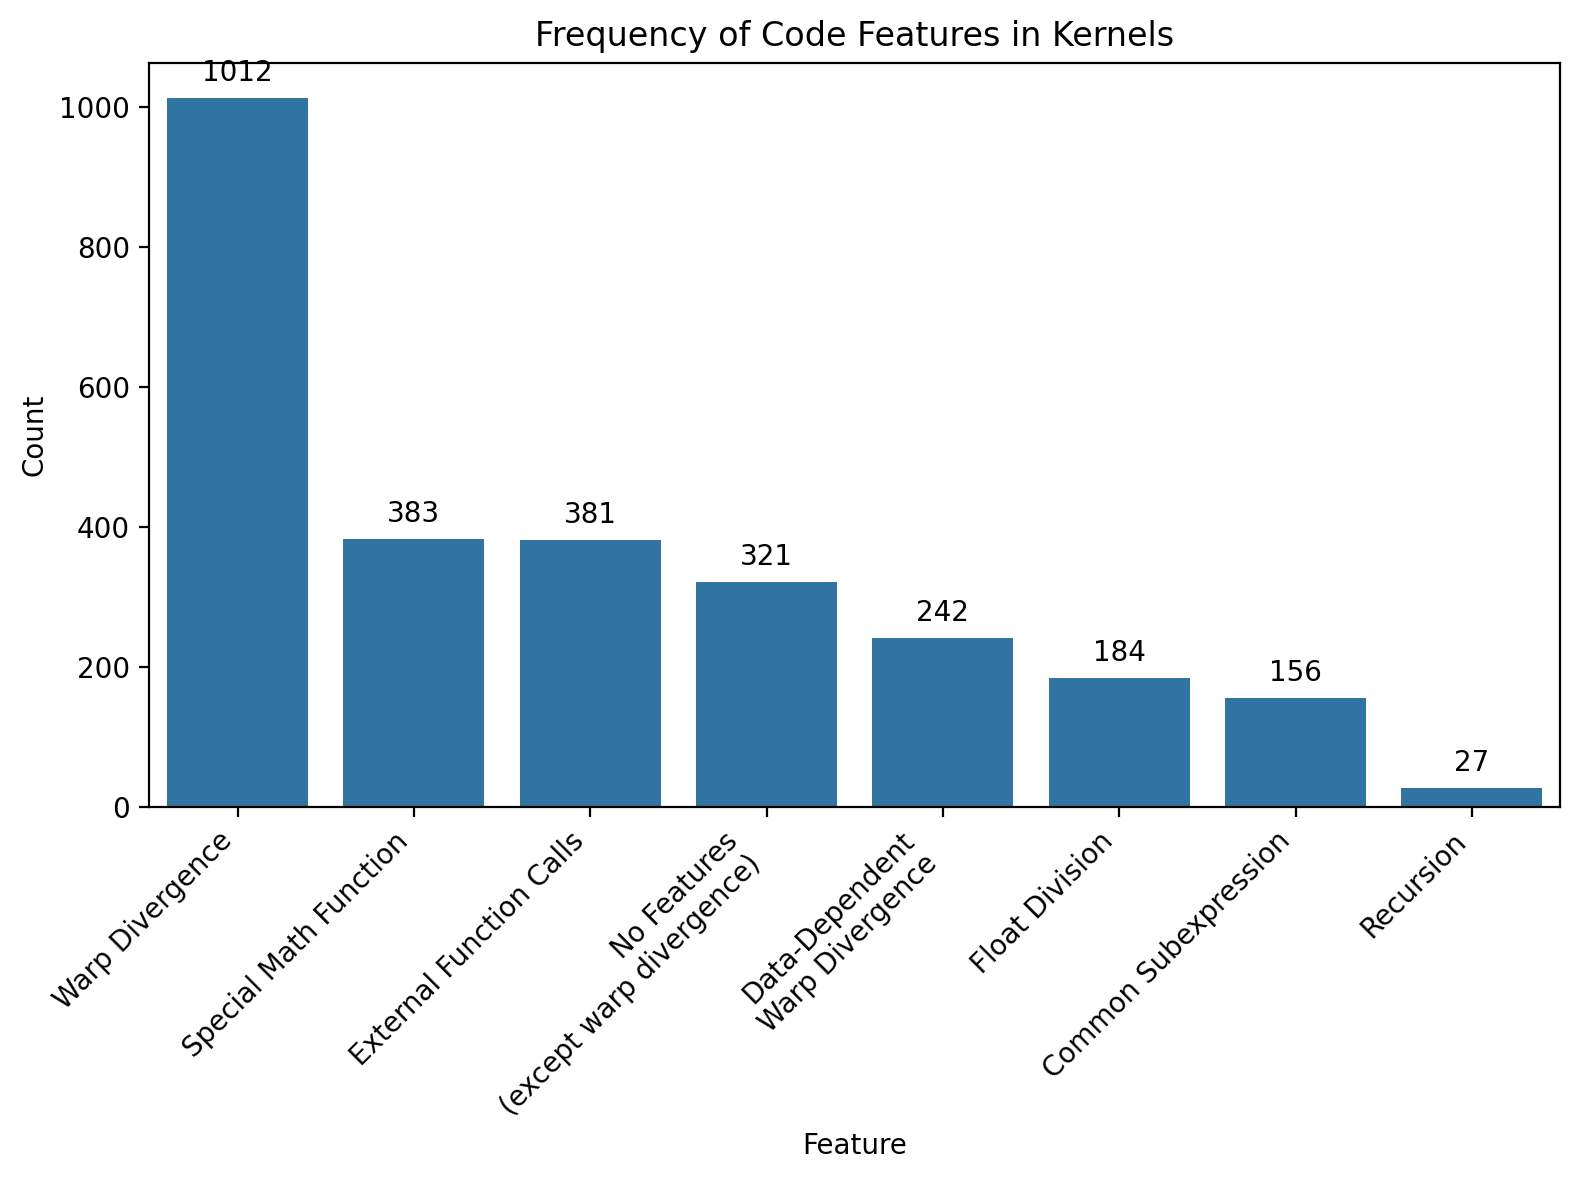

In [4]:
# Create the histogram
plt.figure(figsize=(8, 6), dpi=200)
ax = sns.barplot(x='Feature', y='Number of Kernels', data=df)
plt.title('Frequency of Code Features in Kernels')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')

plt.tight_layout()
plt.show()

In [5]:
# Flatten classification_results.json into DataFrame
import hashlib
rows = []
for program_name, files_dict in data.items():
    for filename, entries in files_dict.items():
        for entry_dict in entries:
            row = {
                'program_name': program_name,
                'filename': filename,
                'source_code': entry_dict.get('source_code', '')
            }
            # Compute MD5 hash of the source code
            row['code_hash'] = hashlib.md5(row['source_code'].encode('utf-8')).hexdigest()
            # Merge with other entry fields
            row = row | entry_dict

            rows.append(row)

df_codes = pd.DataFrame(rows)
df_codes.head()

,program_name,filename,source_code,code_hash,has_float_division,float_division_line_num,has_external_function_calls,external_function_call_line_num,has_recursion,recursion_line_num,has_warp_divergence,warp_divergence_line_num,has_data_dependent_warp_divergence,data_dependent_warp_divergence_line_num,has_common_subexpression,common_subexpression_line_num,has_special_math_function,special_math_function_line_num
0,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,__global__ void\nkernel_likelihood (\n floa...,6782429d54d8b088568a144a0b3174a4,True,"[34, 70, 36, 38, 42, 44]",False,[],False,[],True,"[30, 51, 80, 88, 53, 67, 76, 82, 63, 57, 58]",True,"[63, 57, 58]",True,"[36, 38, 39, 42, 44, 45]",True,"[36, 38, 39, 42, 44, 45, 62, 72]"
1,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,__global__ void\nkernel_sum (float* partial_su...,9fa3bf715227d7d2e7a02c288285d0a4,False,[],False,[],False,[],True,[7],False,[],False,[],False,[]
2,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,__global__ void\nkernel_normalize_weights (\n ...,7133b6bc24910b28a6db7110c862e942,True,"[18, 42, 28, 30, 31]",False,[],False,[],True,"[14, 17, 21, 36, 40, 23]",False,[],True,"[28, 30, 31, 42]",True,"[28, 30, 32]"
3,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,__global__ void\nkernel_find_index (\n cons...,f775eb09d1b2ce46e940523a6b21bf98,False,[],False,[],False,[],True,"[12, 16, 22, 17]",True,[17],False,[],False,[]
4,matrixT-cuda,/Users/gbolet/hecbench-roofline/src/matrixT-cu...,__global__ void copy(\n float *__restri...,ea67a6d850987fba9063938b8aff0d9d,False,[],False,[],False,[],True,[11],False,[],False,[],False,[]


In [6]:
# check for any collisions in the code hashes
hash_collisions = df_codes[df_codes.duplicated(['code_hash'], keep=False)]
print(hash_collisions.shape)

(0, 18)


In [7]:
# group all the codes by their binary features
df_grouped = df_codes.groupby(['has_float_division',                    
                               'has_external_function_calls', 
                               'has_recursion', 'has_warp_divergence', 
                               'has_data_dependent_warp_divergence',
                               'has_common_subexpression', 
                               'has_special_math_function']).size().reset_index(name='count')

# visualize a bar chart of the counts of the grouped features

In [8]:
# check that the group with all False features is empty
featureless_codes = df_codes[(df_codes['has_float_division'] == False) &
                  (df_codes['has_external_function_calls'] == False) &
                  (df_codes['has_recursion'] == False) &
                  (df_codes['has_warp_divergence'] == False) &
                  (df_codes['has_data_dependent_warp_divergence'] == False) &
                  (df_codes['has_common_subexpression'] == False) &
                  (df_codes['has_special_math_function'] == False)]

print(f"Number of codes with no features: {featureless_codes.shape[0]}")

for i, (index, row) in enumerate(featureless_codes.head(10).iterrows()):
    print(f"\n--- Case {i+1} ---")
    print(f"Program: {row['program_name']}")
    print(f"File: {row['filename']}, \nFeatures: [none]\n")
    print(row['source_code'])

Number of codes with no features: 28

--- Case 1 ---
Program: hungarian-cuda
File: /Users/gbolet/hecbench-roofline/src/hungarian-cuda/main.cu, 
Features: [none]

__device__ data min_in_rows[nrows];

__device__ data slack[nrows*ncols];

__global__ void step_1_row_sub()
{
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  int l = i & row_mask;
  slack[i] = slack[i] - min_in_rows[l];  // subtract the minimum in row from that row
}

--- Case 2 ---
Program: hungarian-cuda
File: /Users/gbolet/hecbench-roofline/src/hungarian-cuda/main.cu, 
Features: [none]

__device__ int column_of_prime_at_row[nrows];

__device__ int row_of_green_at_column[ncols];

__global__ void step_4_init()
{
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  column_of_prime_at_row[i] = -1;
  row_of_green_at_column[i] = -1;
}

--- Case 3 ---
Program: vmc-cuda
File: /Users/gbolet/hecbench-roofline/src/vmc-cuda/vmc.cu, 
Features: [none]

#define FLOAT 		1


__global__ void zero_stats(int Npoint, FLOAT* stats) {
  int i = b

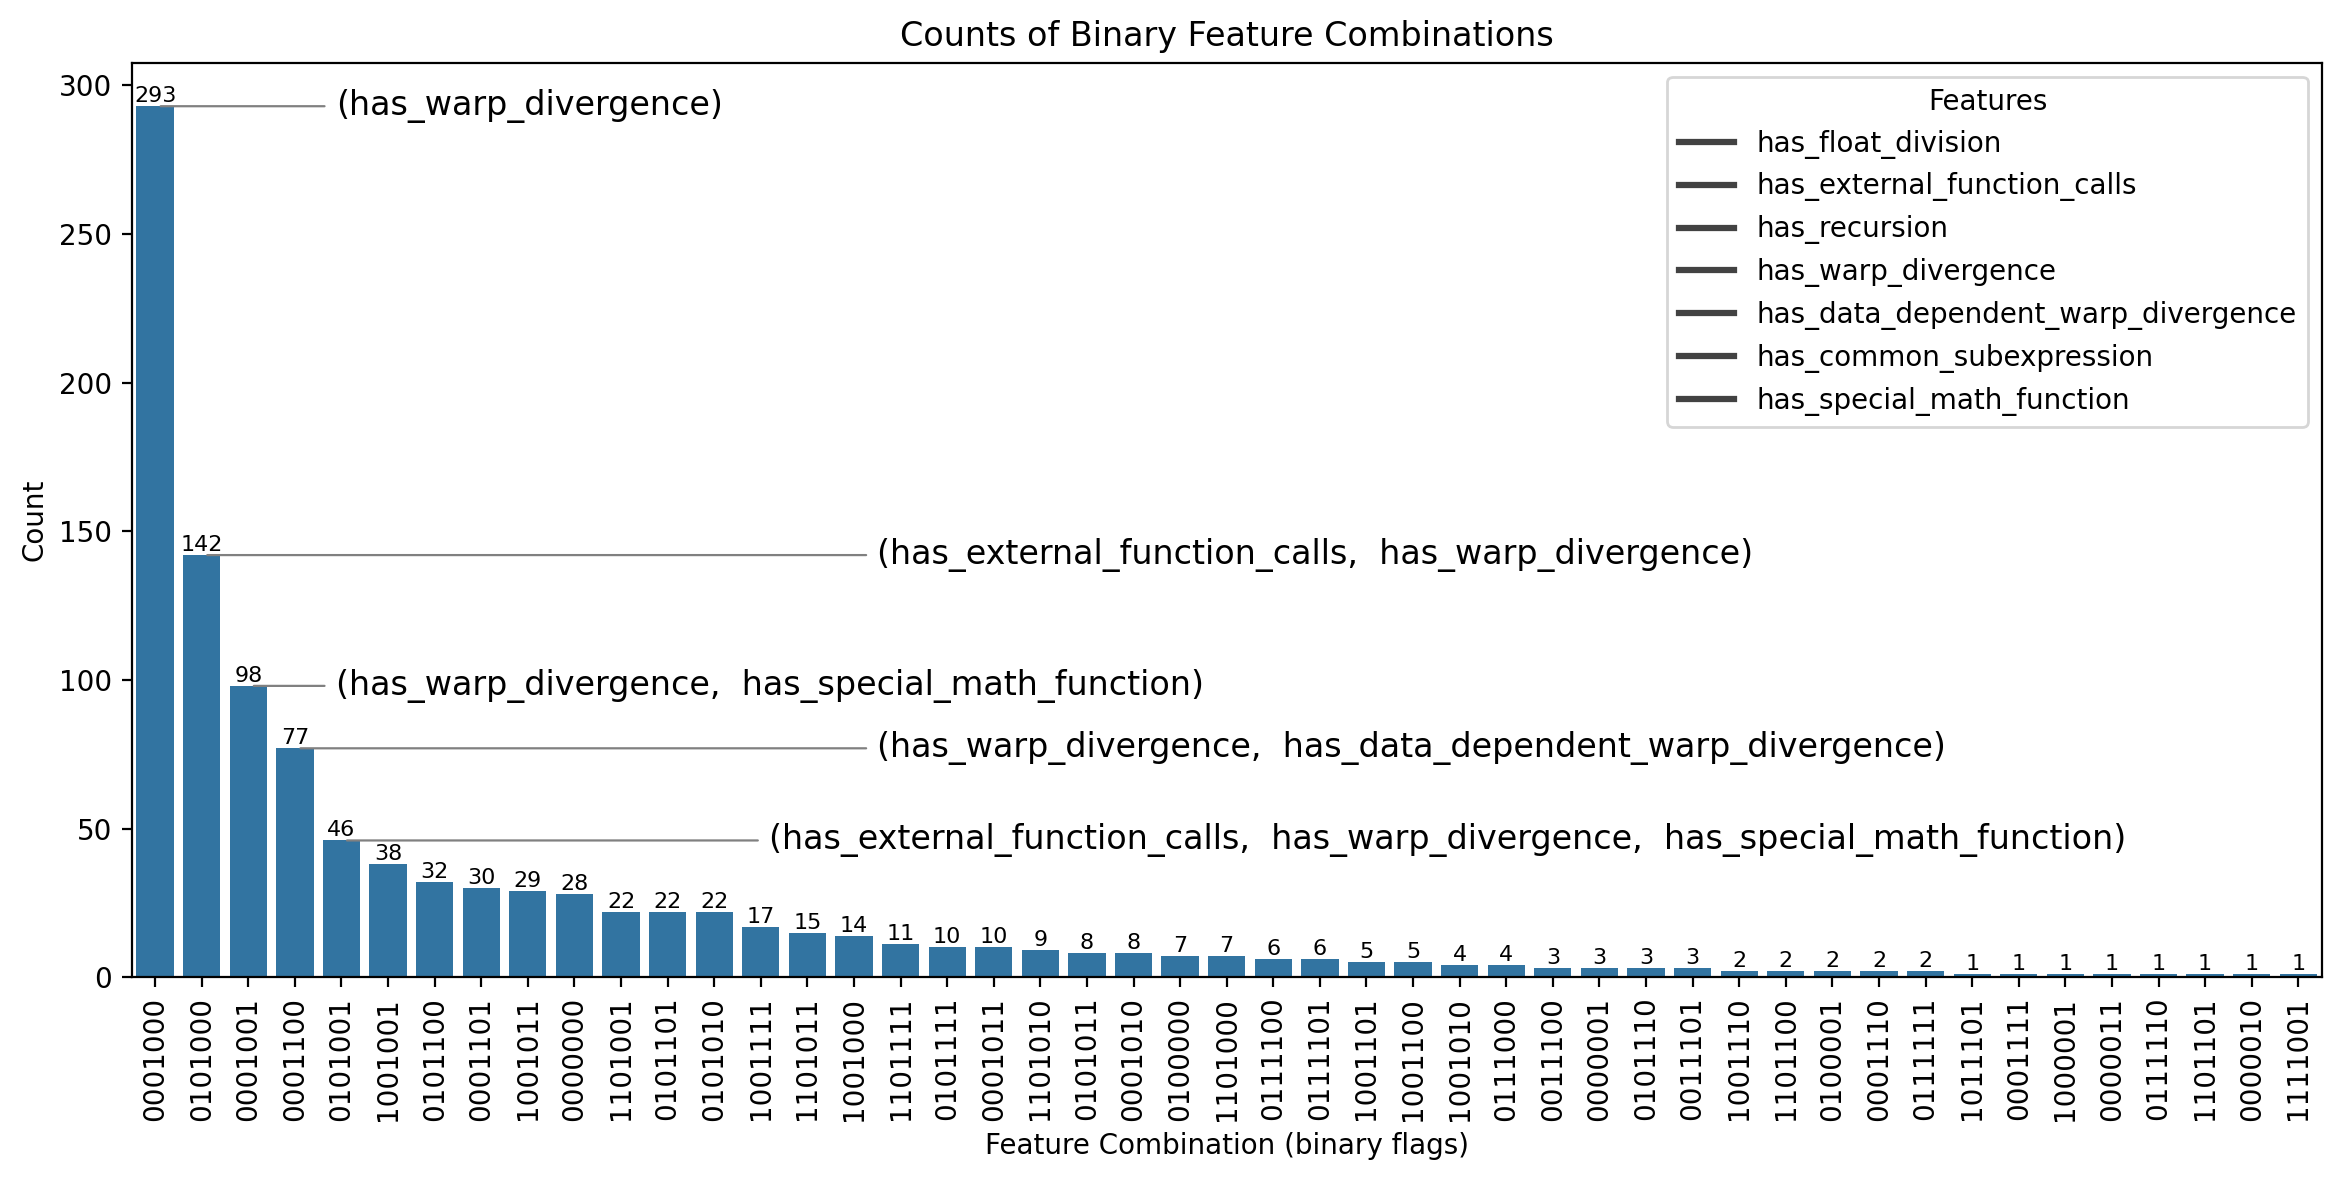

In [9]:
# Plot counts of each binary feature combination, sorted descending and excluding zeros
import textwrap
df_grouped_sorted = df_grouped[df_grouped['count'] > 0].sort_values(by='count', ascending=False)
# Create a label for each combination of binary flags
feature_cols = ['has_float_division', 'has_external_function_calls',
                'has_recursion', 'has_warp_divergence',
                'has_data_dependent_warp_divergence',
                'has_common_subexpression', 'has_special_math_function']
df_grouped_sorted['combination'] = df_grouped_sorted[feature_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)

plt.figure(figsize=(12, 6), dpi=200)
ax = sns.barplot(x='combination', y='count', data=df_grouped_sorted)
plt.title('Counts of Binary Feature Combinations')
plt.xlabel('Feature Combination (binary flags)')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='center')

# Annotate feature tuples (first four only) at right edge inside plot with arrows, and counts above bars
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# shift label_x slightly inside the right boundary
label_x = xlim[1] - (xlim[1] - xlim[0]) * 0.05
# define stagger offsets to prevent text overlap
stagger_offsets = [0, xlim[1]/4, 0, xlim[1]/4, xlim[1]/5]  # stagger offsets for the first five bars

for i, (p, (_, row)) in enumerate(zip(ax.patches, df_grouped_sorted.iterrows())):
    height = p.get_height()
    feature_names = [name for name, flag in zip(feature_cols, row[feature_cols]) if flag]
    tuple_text = f"({',  '.join(feature_names)})" if feature_names else '()'
    # draw arrow annotation for first five bars
    if i < 5:
        ax.annotate(tuple_text,
                    xy=(p.get_x() + p.get_width()/2, height),
                    xytext=(xlim[1]/12+stagger_offsets[i], height),
                    ha='left', va='center', color='black', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
    # annotate count above bar
    ax.annotate(f"{int(height)}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', color='black', fontsize=8)

ax.legend(feature_cols, title='Features')
plt.tight_layout()
plt.show()

In [10]:
# Get the top feature combination
top_combination = df_grouped_sorted.iloc[0]

# Extract the feature columns used for grouping
feature_cols = ['has_float_division', 'has_external_function_calls', 
                'has_recursion', 'has_warp_divergence', 
                'has_data_dependent_warp_divergence',
                'has_common_subexpression', 'has_special_math_function']

# Create a boolean mask for the top combination
mask = (df_codes[feature_cols] == top_combination[feature_cols]).all(axis=1)

# Filter the original DataFrame to get the cases for the top combination
top_cases = df_codes[mask]


# Print the source code of the first fifteen cases
print("Source code for the first fifteen cases of the top binary feature combination:")
for i, (index, row) in enumerate(top_cases.head(30).iterrows()):
    feature_names = [name for name, flag in zip(feature_cols, row[feature_cols]) if flag]
    tuple_text = f"({', '.join(feature_names)})" if feature_names else '()'
    print(f"\n--- Case {i+1} ---")
    print(f"Program: {row['program_name']}")
    print(f"File: {row['filename']}, \nFeatures: {tuple_text}\n")
    print(row['source_code'])



Source code for the first fifteen cases of the top binary feature combination:

--- Case 1 ---
Program: particlefilter-cuda
File: /Users/gbolet/hecbench-roofline/src/particlefilter-cuda/kernel_sum.h, 
Features: (has_warp_divergence)

__global__ void
kernel_sum (float* partial_sums, const int Nparticles)
{
  int x;
  float sum = 0;
  int num_blocks = (Nparticles + BLOCK_SIZE - 1) / BLOCK_SIZE;
  for (x = 0; x < num_blocks; x++) {
    sum += partial_sums[x];
  }
  partial_sums[0] = sum;
}

--- Case 2 ---
Program: matrixT-cuda
File: /Users/gbolet/hecbench-roofline/src/matrixT-cuda/main.cu, 
Features: (has_warp_divergence)

__global__ void copy(
        float *__restrict__ odata,
  const float *__restrict__ idata,
  int width, int height)
{
  int xIndex = blockIdx.x * TILE_DIM + threadIdx.x;
  int yIndex = blockIdx.y * TILE_DIM + threadIdx.y;

  int index  = xIndex + width*yIndex;

  for (int i=0; i<TILE_DIM; i+=BLOCK_ROWS)
  {
    odata[index+i*width] = idata[index+i*width];
  }
}

--- Ca